# **Task 1**

In [0]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import preprocessing
import numpy as np
import tarfile
import os

In [0]:
print(__doc__)
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

Automatically created module for IPython interactive environment


In [0]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [0]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [0]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces_150 = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca_150 = pca.transform(X_train)
X_test_pca_150 = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 0.508s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.035s


**1. Change the parameter grid for ‘C’ to include the values (1, 10, 100, 1e3).**

In [0]:
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1, 10, 100, 1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
clf = clf.fit(X_train_pca_150, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 112.704s
Best estimator found by grid search:
SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [0]:
# Quantitative evaluation of the model quality on the test set using 150 principal components

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca_150)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
print('accuracy_score: ', clf.score(X_test_pca_150, y_test))

Predicting people's names on the test set
done in 0.078s
                   precision    recall  f1-score   support

     Ariel Sharon       0.53      0.69      0.60        13
     Colin Powell       0.80      0.85      0.82        60
  Donald Rumsfeld       0.69      0.74      0.71        27
    George W Bush       0.93      0.86      0.90       146
Gerhard Schroeder       0.61      0.80      0.69        25
      Hugo Chavez       0.73      0.53      0.62        15
       Tony Blair       0.82      0.75      0.78        36

      avg / total       0.82      0.81      0.81       322

[[  9   0   3   1   0   0   0]
 [  3  51   1   3   0   1   1]
 [  5   0  20   1   0   0   1]
 [  0   7   4 126   6   1   2]
 [  0   2   0   1  20   1   1]
 [  0   2   0   1   3   8   1]
 [  0   2   1   2   4   0  27]]
accuracy_score:  0.8105590062111802


**2. Now, disable PCA. That is, feed the images from lfw_people directly to the SVM, without applying PCA. Note that you now need to standardize the data.**

In [0]:
# standardize the data
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [0]:
# split the standardized data into a training and testing set
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42)

In [0]:
# Train a SVM classification model without using PCA
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1, 10, 100, 1e3, 5e3, 1e4],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
clf = clf.fit(X_train_scaled, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 1001.882s
Best estimator found by grid search:
SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


With PCA:  the classifier had the best performance when C was equal to 10. Thus, the best value of C is 10, which is small enough to better tolerate misclassified points.


Without PCA: the classifier had the best performance when C was equal to 100. 

In [0]:
# Quantitative evaluation of the model quality on the test set without PCA

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_scaled)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
print('accuracy_score: ' ,clf.score(X_test_scaled, y_test))

Predicting people's names on the test set
done in 0.744s
                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.69      0.58        13
     Colin Powell       0.79      0.92      0.85        60
  Donald Rumsfeld       0.78      0.67      0.72        27
    George W Bush       0.93      0.92      0.93       146
Gerhard Schroeder       0.80      0.80      0.80        25
      Hugo Chavez       0.91      0.67      0.77        15
       Tony Blair       0.90      0.75      0.82        36

      avg / total       0.86      0.85      0.85       322

[[  9   1   3   0   0   0   0]
 [  2  55   0   2   0   1   0]
 [  4   1  18   3   0   0   1]
 [  2   6   1 135   2   0   0]
 [  0   1   0   2  20   0   2]
 [  0   3   0   1   1  10   0]
 [  1   3   1   2   2   0  27]]
accuracy_score:  0.8509316770186336


The best Classifier performance is the one used without PCA,. because it has better values of precesion, recall and test score.
Test score with PCA: 0.8105590062111802 
Test score withput PCA : 0.8509316770186336

**3. Now, go back to using PCA. Vary the number of principal components you use as an input to the classifier [50, 150, 190, 300, 1000]. Plot the number of principal components on the x-axis, and the performance and the corresponding C values found by grid search on the Y-axis.**

In [0]:
# Train the SVM Using 50 principal components
n_components = 50
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
eigenfaces_50 = pca.components_.reshape((n_components, h, w))
X_train_pca_50 = pca.transform(X_train)
X_test_pca_50 = pca.transform(X_test)

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1, 10, 100, 1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
clf = clf.fit(X_train_pca_50, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 38.320s
Best estimator found by grid search:
SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [0]:
# Quantitative evaluation of the model quality on the test set using 50 principal components

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca_50)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
print('accuracy_score: ' ,clf.score(X_test_pca_50, y_test))

Predicting people's names on the test set
done in 0.033s
                   precision    recall  f1-score   support

     Ariel Sharon       0.62      0.77      0.69        13
     Colin Powell       0.83      0.92      0.87        60
  Donald Rumsfeld       0.62      0.56      0.59        27
    George W Bush       0.88      0.91      0.89       146
Gerhard Schroeder       0.70      0.64      0.67        25
      Hugo Chavez       0.75      0.60      0.67        15
       Tony Blair       0.83      0.67      0.74        36

      avg / total       0.81      0.81      0.81       322

[[ 10   1   1   1   0   0   0]
 [  0  55   1   3   1   0   0]
 [  4   3  15   4   1   0   0]
 [  0   3   4 133   1   2   3]
 [  0   0   2   5  16   1   1]
 [  0   2   0   2   1   9   1]
 [  2   2   1   4   3   0  24]]
accuracy_score:  0.8136645962732919


In [0]:
# Train the SVM Using 190 principal components
n_components = 190
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
eigenfaces_190 = pca.components_.reshape((n_components, h, w))
X_train_pca_190 = pca.transform(X_train)
X_test_pca_190 = pca.transform(X_test)

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1, 10, 100, 1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
clf = clf.fit(X_train_pca_190, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 113.888s
Best estimator found by grid search:
SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [0]:
# Quantitative evaluation of the model quality on the test set 190 principal components

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca_190)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
print('accuracy_score: ' ,clf.score(X_test_pca_190, y_test))

Predicting people's names on the test set
done in 0.098s
                   precision    recall  f1-score   support

     Ariel Sharon       0.62      0.77      0.69        13
     Colin Powell       0.78      0.90      0.84        60
  Donald Rumsfeld       0.83      0.74      0.78        27
    George W Bush       0.93      0.89      0.91       146
Gerhard Schroeder       0.78      0.84      0.81        25
      Hugo Chavez       0.70      0.47      0.56        15
       Tony Blair       0.83      0.83      0.83        36

      avg / total       0.85      0.84      0.84       322

[[ 10   1   0   2   0   0   0]
 [  2  54   0   3   0   1   0]
 [  3   2  20   1   0   1   0]
 [  1   7   2 130   2   1   3]
 [  0   2   0   1  21   0   1]
 [  0   3   0   1   2   7   2]
 [  0   0   2   2   2   0  30]]
accuracy_score:  0.84472049689441


In [0]:
# Train the SVM Using 300 principal components
n_components = 300
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
eigenfaces_300 = pca.components_.reshape((n_components, h, w))
X_train_pca_300 = pca.transform(X_train)
X_test_pca_300 = pca.transform(X_test)

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1, 10, 100, 1e3, 5e3, 1e4],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
clf = clf.fit(X_train_pca_300, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 179.288s
Best estimator found by grid search:
SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [0]:
# Quantitative evaluation of the model quality on the test set 300 principal components

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca_300)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
print('accuracy_score: ' ,clf.score(X_test_pca_300, y_test))

Predicting people's names on the test set
done in 0.156s
                   precision    recall  f1-score   support

     Ariel Sharon       0.42      0.62      0.50        13
     Colin Powell       0.79      0.87      0.83        60
  Donald Rumsfeld       0.68      0.70      0.69        27
    George W Bush       0.93      0.79      0.86       146
Gerhard Schroeder       0.58      0.72      0.64        25
      Hugo Chavez       0.60      0.60      0.60        15
       Tony Blair       0.72      0.81      0.76        36

      avg / total       0.80      0.78      0.78       322

[[  8   1   3   0   1   0   0]
 [  3  52   2   1   0   2   0]
 [  3   1  19   0   2   1   1]
 [  4   7   4 115   7   2   7]
 [  0   1   0   3  18   1   2]
 [  0   2   0   1   2   9   1]
 [  1   2   0   3   1   0  29]]
accuracy_score:  0.7763975155279503


In [0]:
# Train the SVM Using 700 principal components
n_components = 700
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
eigenfaces = pca.components_.reshape((n_components, h, w))
X_train_pca_700 = pca.transform(X_train)
X_test_pca_700 = pca.transform(X_test)

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1, 10, 100, 1e3, 5e3, 1e4],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
clf = clf.fit(X_train_pca_700, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 422.675s
Best estimator found by grid search:
SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [0]:
# Quantitative evaluation of the model quality on the test set 700 principal components

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca_700)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
print('accuracy_score: ' ,clf.score(X_test_pca_700, y_test))

Predicting people's names on the test set
done in 0.359s
                   precision    recall  f1-score   support

     Ariel Sharon       0.56      0.77      0.65        13
     Colin Powell       0.54      0.83      0.65        60
  Donald Rumsfeld       0.39      0.63      0.48        27
    George W Bush       0.94      0.64      0.76       146
Gerhard Schroeder       0.67      0.48      0.56        25
      Hugo Chavez       0.53      0.60      0.56        15
       Tony Blair       0.62      0.56      0.59        36

      avg / total       0.73      0.66      0.67       322

[[10  1  1  0  1  0  0]
 [ 2 50  3  1  0  2  2]
 [ 2  6 17  1  0  0  1]
 [ 3 23 18 94  0  3  5]
 [ 0  4  2  1 12  3  3]
 [ 0  2  1  0  2  9  1]
 [ 1  7  2  3  3  0 20]]
accuracy_score:  0.6583850931677019


** Plot the number of principal components on the x-axis, and the performance and the corresponding C values found by grid search on the Y-axis.**

<function matplotlib.pyplot.show>

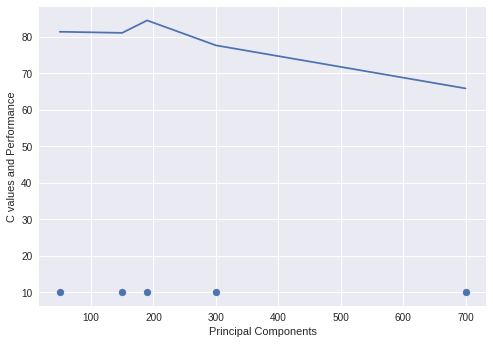

In [0]:
x = [50, 150, 190, 300, 700]
y = [10, 10, 10, 10, 10]
test_scores = [0.8136645962732919, 0.8105590062111802, 0.84472049689441 , 0.7763975155279503, 0.6583850931677019]
performance = [i * 100 for i in test_scores]

plt.xlabel('Principal Components')
plt.ylabel('C values and Performance')
plt.scatter(x,y)
plt.plot(x, performance)
plt.show


**4. Report on the change in performance you observe. What causes the performance to change with respect to the number of principal components in this particular manner?**

Increasing the number of principal components might not always enhance performance because, some components are not very important for the classification process and will just cause more hazard of extra uneeded calculations. which was the case when we increased the principal components to 300 and 700. So, the best performance was when we chose avaerage number of principal components, which is 190. Also, very few principal components will not be enough to classify correctly so using a classifier on 50 principal components only didn't achieve good results.

**5. Use the best classifier found by the gridsearch above. Save the eigenface plots produced by the last part in the tutorial using the best configurations (best number of principal components and best classifier parameters).**

best number of principal components is 190  and best claasifies parametrs are: SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

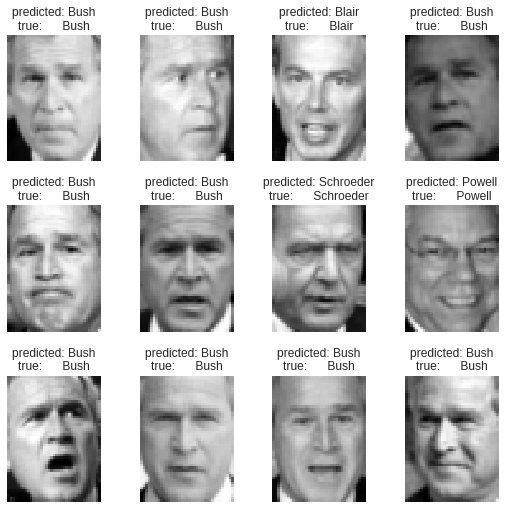

In [0]:
# plot the result of the prediction on a portion of the test set
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)


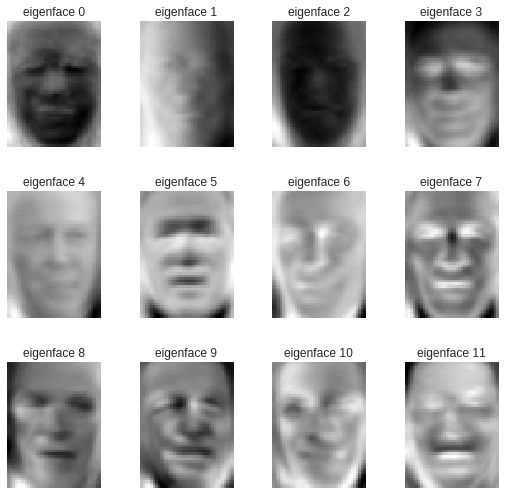

In [0]:
# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces_190.shape[0])]
plot_gallery(eigenfaces_190, eigenface_titles, h, w)

plt.show()

**6. Now, change the dataset to the ‘unfunneled’ version. Report the change in performance.**

In [0]:
unfunneled_lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4, funneled= False)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = unfunneled_lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = unfunneled_lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = unfunneled_lfw_people.target
target_names = unfunneled_lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [0]:
# split into a training and testing set
X_train_unfunneled, X_test_unfunneled, y_train_unfunneled, y_test_unfunneled= train_test_split(
    X, y, test_size=0.25, random_state=42)

In [0]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 190

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train_unfunneled.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train_unfunneled)
print("done in %0.3fs" % (time() - t0))

eigenfaces_unfunneled = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca_unfunneled = pca.transform(X_train_unfunneled)
X_test_pca_unfunneled = pca.transform(X_test_unfunneled)
print("done in %0.3fs" % (time() - t0))

Extracting the top 190 eigenfaces from 966 faces
done in 0.413s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.038s


In [0]:
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
clf = SVC(C= 10, gamma= 0.001, kernel='rbf', class_weight='balanced')
clf = clf.fit(X_train_pca_unfunneled, y_train_unfunneled)
print("done in %0.3fs" % (time() - t0))

Fitting the classifier to the training set
done in 0.375s


In [0]:
# Quantitative evaluation of the model quality on the test set using 190 principal components

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca_unfunneled)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test_unfunneled, y_pred, target_names=target_names))
print(confusion_matrix(y_test_unfunneled, y_pred, labels=range(n_classes)))
print('accuracy_score: ' ,clf.score(X_test_pca_unfunneled, y_test_unfunneled))

Predicting people's names on the test set
done in 0.080s
                   precision    recall  f1-score   support

     Ariel Sharon       0.89      0.62      0.73        13
     Colin Powell       0.78      0.88      0.83        60
  Donald Rumsfeld       0.72      0.78      0.75        27
    George W Bush       0.89      0.86      0.88       146
Gerhard Schroeder       0.68      0.68      0.68        25
      Hugo Chavez       0.67      0.67      0.67        15
       Tony Blair       0.66      0.64      0.65        36

      avg / total       0.80      0.80      0.80       322

[[  8   1   2   1   0   1   0]
 [  0  53   1   3   0   1   2]
 [  1   1  21   1   1   0   2]
 [  0   5   4 126   3   1   7]
 [  0   2   1   3  17   1   1]
 [  0   2   0   2   1  10   0]
 [  0   4   0   5   3   1  23]]
accuracy_score:  0.8012422360248447


Performance of the classifier when using funneled data was better than performance when using unfunneled data. because precesion and recall were higher and also the alignment of images improved accuracy.
Additionally, funneling improves the subsequent alignment of facial images which is used to improve positioning for subsequent processing, such as an identification task.

**7. Compare the Eigenfaces plotted in the last part of the tutorial for both the ‘funneled’ and ‘unfunneled’ datasets. You will need to observe the corresponding plots closely. It’s normal that the luminance differs between the two sets of principal components. What is the other side effect of using unfunneled images on the eigenfaces?**

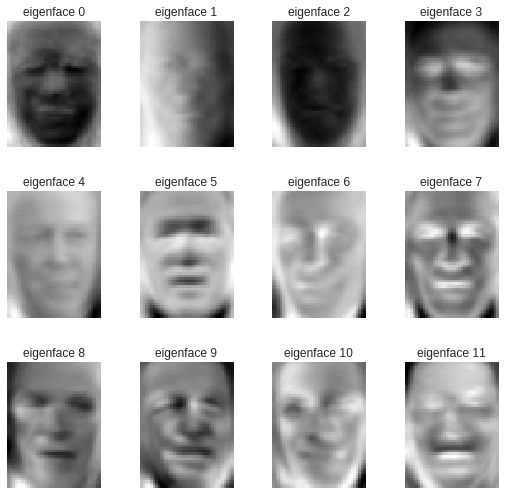

In [0]:
# plot the gallery of the most significative unfunneled eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces_unfunneled.shape[0])]
plot_gallery(eigenfaces_unfunneled, eigenface_titles, h, w)

plt.show()

Unfenneled Version

The funneled version of eigenfaces has more sharpness at the edges and this is because alignment method improves performance on a face recognition task.

**8. Go back to using the best performing classifier and the funneled dataset. Run this classifier using the CPU runtime, the GPU runtime and the TPU runtime. Report the observed speedup if any.**

CPU Time

In [0]:
# Train the SVM Using 190 principal components (Funneled)
n_components = 190
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
eigenfaces_190 = pca.components_.reshape((n_components, h, w))
X_train_pca_190 = pca.transform(X_train)
X_test_pca_190 = pca.transform(X_test)

print("Fitting the classifier to the training set")
t0 = time()
clf = SVC(C= 10, gamma= 0.001, kernel='rbf', class_weight='balanced')
clf = clf.fit(X_train_pca_190, y_train)
print("done in %0.3fs" % (time() - t0))

Fitting the classifier to the training set
done in 0.450s


GPU Time

In [0]:
# Train the SVM Using 190 principal components (Funneled)
n_components = 190
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
eigenfaces_190 = pca.components_.reshape((n_components, h, w))
X_train_pca_190 = pca.transform(X_train)
X_test_pca_190 = pca.transform(X_test)

print("Fitting the classifier to the training set")
t0 = time()
clf = SVC(C= 10, gamma= 0.001, kernel='rbf', class_weight='balanced')
clf = clf.fit(X_train_pca_190, y_train)
print("done in %0.3fs" % (time() - t0))

Fitting the classifier to the training set
done in 0.386s


TPU Time

In [0]:
# Train the SVM Using 190 principal components (Funneled)
n_components = 190
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
eigenfaces_190 = pca.components_.reshape((n_components, h, w))
X_train_pca_190 = pca.transform(X_train)
X_test_pca_190 = pca.transform(X_test)

print("Fitting the classifier to the training set")
t0 = time()
clf = SVC(C= 10, gamma= 0.001, kernel='rbf', class_weight='balanced')
clf = clf.fit(X_train_pca_190, y_train)
print("done in %0.3fs" % (time() - t0))

Fitting the classifier to the training set
done in 0.482s


there is no significant differences between running in CPU, TPU, and GPU times, and that is because scikit-learn doen't support running in GPU or TPU. it only runs in CPU time. this answer is based on this resource : https://stackoverflow.com/questions/41567895/will-scikit-learn-utilize-gpu?fbclid=IwAR3xo3J_LVAN5_bbq4CBC88mAw1q0BxIqKjgtk16IeA3VWGXBaogqyxDRT0